In [ ]:
import matplotlib.pyplot as plt

import pandas as pd
from pathlib import Path

import scipy.stats as stats
import seaborn as sns

from statsmodels.stats.anova import AnovaRM


In [58]:
sns.set_style("darkgrid")

In [48]:
derivative_dir = Path("..") / "derivatives"
assert derivative_dir.exists()
peaks_dir = derivative_dir / "peaks" / "run-01"

df_qc = pd.read_csv(Path(peaks_dir / "n1_troughs_QCR.csv").resolve())
df_ll = pd.read_csv(Path(peaks_dir / "n1_troughs_pylossless.csv"))
df_prep = pd.read_csv(Path(peaks_dir / "n1_troughs_pyprep.csv"))
df_raw = pd.read_csv(Path(peaks_dir / "n1_troughs_raw.csv"))

In [49]:
for this_df in [df_qc, df_ll, df_prep, df_raw]:
    this_df["identifier"] = this_df["file"].str.split("_proc").str[0]

$ N = 

In [91]:
df_1 = pd.merge(
    df_ll[["identifier", "snr"]],
    df_qc[["identifier", "snr"]],
    on="identifier",
    how="inner",
    suffixes=("_ll", "_qc")
)

df_2 = pd.merge(
    df_raw[["identifier", "snr"]],
    df_prep[["identifier", "snr"]],
    on="identifier",
    how="inner",
    suffixes=("_raw", "_prep")
)

df = pd.merge(
    df_1, df_2, on="identifier", how="inner",
)
df = df.melt(
    id_vars="identifier",
    var_name="method",
    value_name="snr"
)
df["method"] = df["method"].replace({"snr_ll": "pylossless", "snr_qc": "QCR", "snr_prep": "pyPREP", "snr_raw": "raw"})
df

,identifier,method,snr
0,phonemes_2027_20231218,pylossless,5.754663
1,phonemes_2043_20240328_114345,pylossless,13.137426
2,phonemes_2064_20240802_031713,pylossless,6.322542
3,phonemes_2033_20240117_043649,pylossless,4.749408
4,phonemes_2050_20240606_110702,pylossless,11.410212
...,...,...,...
123,phonemes_2029_20231221,pyPREP,20.177910
124,phonemes_2059_20240801_121559,pyPREP,13.173934
125,phonemes_2062_20240725_113431,pyPREP,18.113140
126,phonemes_2054_20240620_112330,pyPREP,9.816364


In [92]:
aovrm = AnovaRM(df, depvar='snr', subject='identifier', within=['method'])
res = aovrm.fit()
print(res)

               Anova
       F Value Num DF  Den DF Pr > F
------------------------------------
method  6.8191 3.0000 93.0000 0.0003



In [93]:
import pingouin as pg

rmANOVA = pg.rm_anova(data=df, dv='snr', within='method',
                      subject='identifier', detailed=True)
rmANOVA

,Source,SS,DF,MS,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,method,352.608478,3,117.536159,6.819064,0.000333,0.003299,0.06216,0.58636,False,0.356374,0.000011
1,Error,1602.985729,93,17.236406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
df

,identifier,method,snr
0,phonemes_2027_20231218,pylossless,5.754663
1,phonemes_2043_20240328_114345,pylossless,13.137426
2,phonemes_2064_20240802_031713,pylossless,6.322542
3,phonemes_2033_20240117_043649,pylossless,4.749408
4,phonemes_2050_20240606_110702,pylossless,11.410212
...,...,...,...
123,phonemes_2029_20231221,pyPREP,20.177910
124,phonemes_2059_20240801_121559,pyPREP,13.173934
125,phonemes_2062_20240725_113431,pyPREP,18.113140
126,phonemes_2054_20240620_112330,pyPREP,9.816364


In [94]:
# pairwise comparisons
pairwise_tests = pg.pairwise_tests(data=df, dv='snr', within='method',
                                    subject='identifier',padjust='holm')
print(pairwise_tests)

  Contrast           A           B  Paired  Parametric         T   dof  \
0   method         QCR      pyPREP    True        True  3.533673  31.0   
1   method         QCR  pylossless    True        True  1.944395  31.0   
2   method         QCR         raw    True        True  2.301738  31.0   
3   method      pyPREP  pylossless    True        True -2.770173  31.0   
4   method      pyPREP         raw    True        True -2.531006  31.0   
5   method  pylossless         raw    True        True  1.300689  31.0   

  alternative     p-unc    p-corr p-adjust    BF10    hedges  
0   two-sided  0.001309  0.007855     holm  25.664  0.666533  
1   two-sided  0.060970  0.121940     holm   0.998  0.180678  
2   two-sided  0.028232  0.084697     holm   1.853  0.415219  
3   two-sided  0.009381  0.046905     holm   4.652 -0.475889  
4   two-sided  0.016664  0.066654     holm   2.867 -0.279660  
5   two-sided  0.202951  0.202951     holm   0.407  0.221520  


In [52]:
from statsmodels.stats.multitest import multipletests
from itertools import combinations

# Make sure your data is in long format:
# columns: ['subject', 'processing_method', 'snr']

# Pivot to wide format for paired comparisons
df_wide = df.pivot(index='identifier', columns='method', values='snr')

methods = df_wide.columns
pairs = list(combinations(methods, 2))

# Run paired t-tests
results = []
for m1, m2 in pairs:
    if "pyPREP" in (m1, m2) and "raw" not in (m1, m2):
        continue
    elif "QCR" in (m1, m2) and "pylossless" in (m1, m2):
        continue
    tstat, pval = stats.ttest_rel(df_wide[m1], df_wide[m2])
    results.append({
        'comparison': f"{m1} vs {m2}",
        't-stat': tstat,
        'p-value': pval
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Correct p-values for multiple comparisons (e.g., Holm or Bonferroni)
# Not using Bonferonni because it assumes the tests are independent (they are not)
results_df['p-adjusted'] = multipletests(results_df['p-value'], method='holm')[1]

print(results_df)

          comparison    t-stat   p-value  p-adjusted
0         QCR vs raw  2.301738  0.028232    0.056464
1      pyPREP vs raw -2.531006  0.016664    0.049991
2  pylossless vs raw  1.300689  0.202951    0.202951


<Axes: xlabel='method', ylabel='snr'>

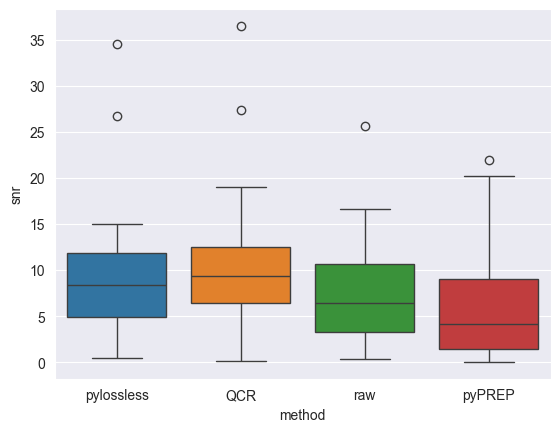

In [59]:
sns.boxplot(data=df, x="method", y="snr", hue="method")